In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.linalg import norm
import itertools as it
import seaborn as sns
from pathlib import Path
np.set_printoptions(precision=2)
FIG_DIR  = Path("../Plots")
FIG_SFXS = [".pdf",".png"]

# Polyphase Decomposition of a Sinusoidal Signal

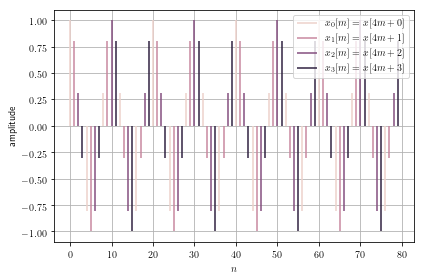

In [8]:
# Input Parameters
N_sps   = 10 # Number of samples per symbol (period of sinusoid)
N_sym   = 8  # Number symbols (number of sinusoid periods)
N_phs   = 4  # Number of phases in decomposition

# Polyphase Decomposition
N_sam = np.ceil(N_sps*N_sym/N_phs)*N_phs # Number of samples; pad to multiple of N_phs
ll_l  = np.arange(N_phs)                 # phase index 
mm_m  = np.arange(N_sam/N_phs)           # sample index at reduced rate (rate-change factor 1/N_phs)
nn_n  = np.arange(N_sam)                 # sample index at original rate
nn_lm = nn_n.reshape(N_phs,-1,order="F") # corresponding sample times
xx_n  = np.cos(2*np.pi/N_sps*nn_n)       # sinusoidal signal
xx_lm = xx_n.reshape(N_phs,-1,order="F") # polyphase decomposition (order="F" so that axis 0 changes fast)

def mystem(ax,x,y,**kwds):
    """
    Stem plot without markers.
    
    Parameters:
        ax - Axis to plot on.
        x, y - data to plot
    """
    return ax.vlines(x,np.minimum(0,y),np.maximum(0,y),**kwds)


# Color Palette for phases
palette_l = sns.cubehelix_palette(N_phs)

# Plot polyphase components of x[n] on same Figure
fig, ax = plt.subplots()
ax.set_xlabel("$n$")
ax.set_ylabel("amplitude")
for l_0 in ll_l:
    mystem(ax,nn_lm[l_0,:],xx_lm[l_0,:],
           color=palette_l[l_0],
           label=r"$x_{}[m] = x[{}m+{}]$".format(l_0,N_phs,l_0))
ax.legend()

# Export Figure
fig.tight_layout()
for sfx in FIG_SFXS:
    fig.savefig(FIG_DIR.joinpath("polyphase").with_suffix(sfx))

# CIC Decimation Filter Frequency Response

In [3]:
def cic(R,N=2,M=2,debug=True):
    """
    Parameters:
        R - rate change factor
        M - comb will be (1-z^(-M))
        N - number of integrator/comb pairs

    Returns:
        b - numerator polynomial
        a - denominator polynomial
    """
    b = np.poly1d(np.ones(M*R))/M  # x^{MR-1} + ... + x^2 + x + 1
    a = np.poly1d(np.zeros(M*R)); a[M*R-1] = 1; # x^{MR-1}
    return b**N, a**N

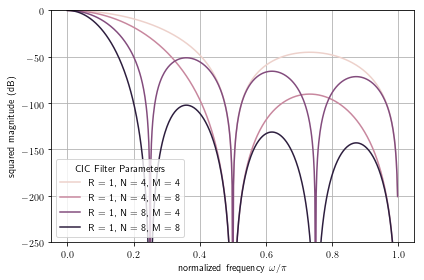

In [9]:
# Input paramters
RR_i = np.array([1])         # Rate Change Factors
NN_j = np.array([4,8]);      # Number of comb-integrator pairs
MM_k = np.array([4,8]);      # Order of comb
FIGNAME = "cic_response"

# Parameter Grid iterators
ii = np.arange(RR_i.size)
jj = np.arange(NN_j.size)
kk = np.arange(MM_k.size)

# Plot CIC filter frequency response 
fig, ax = plt.subplots()
ax.set_prop_cycle(color = sns.cubehelix_palette(ii.size*jj.size*kk.size))
ax.set_xlabel("normalized frequency $\omega/\pi$")
ax.set_ylabel("squared magnitude (dB)")
ax.set_ylim(-250,0)
for k_0, j_0, i_0 in it.product(kk,jj,ii):
    R, N, M = RR_i[i_0], NN_j[j_0], MM_k[k_0]
    b, a    = cic(R,N,M)
    w, H    = signal.freqz(b,a,fs=2)
    label   = r"R = {}, N = {}, M = {}".format(R,M,N)
    ax.plot(w,20*np.log10(np.abs(H)),label=label)
ax.legend(title="CIC Filter Parameters")
fig.tight_layout()

# Export figure
for sfx in FIG_SFXS:
    fig.savefig(FIG_DIR.joinpath(FIGNAME).with_suffix(sfx))